In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [7]:
h = .0001

# inputs
a = 2
b = -3
c = 10

d1 = a*b + c
a += h
d2 = a*b + c

print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/h)

d1 4
d2 3.999699999999999
slope -3.000000000010772


In [8]:
from graphviz import Digraph

def trace(root):
  """Builds a set of all nodes and edges in a graph."""
  nodes, edges = set(), set()

  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)

  build(root)
  return nodes, edges

def draw_dot(root):
  """Creates a Digraph representation of the graph."""
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'})  # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # For any value in the graph, create a rectangular ('record') node for it.
    dot.node(name=uid, label="{ %s | data %.4f | grad % .4f }" % (n.label, n.data, n.grad), shape="record")

    if n._op:
      # If this value is a result of some operation, create an op node.
      dot.node(name=uid + n._op, label=n._op)
      # And connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # Connect nl to the op node of n2.
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [9]:
class Value:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"Value(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)        
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only support int/float power for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out

    def __truediv__(self, other):  # self / other
        return self * other**-1

    def __neg__(self):  # -self
        return self * -1
    
    def __sub__(self, other):  # self - other
        return self + (-other)

    def __rsub__(self, other): # other - self
        return other + (-self)

    def tanh(self):
        x = self.data
        t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
        out = Value(t, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - t**2) * out.grad
        out._backward = _backward

        return out

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad
        out._backward = _backward

        return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [ ]:
a = Value(2.0)
b = Value(4.0)
a / b
a - b
a.exp()
# b = 3 * a
# c = a * 3
# d = a * a
# print(f'a: {a}')
# print(f'b: {b}')
# print(f'c: {c}')
# print(f'd: {d}')

In [74]:
class V:

    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda : None
        self._prev = set(_children)
        self._op = _op
        self.label = label

    def __repr__(self) -> str:
        return f"V(data = {self.data})"
    
    def __add__(self, other):
        other = other if isinstance(other, V) else V(other)
        out = V(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0 * out.grad
        out._backward = _backward    

        print(f'+self.grad: {self.grad}')
        print(f'+out.grad: {out.grad}')
        print(f'+other.grad: {other.grad}')
        print(f'+out._backward: {out._backward}')
        print(f'+out: {out}')
        print('----')

        return out

    def __radd__(self, other): # other + self
        return self + other

    def __mul__(self, other):
        other = other if isinstance(other, V) else V(other)        
        out = V(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward

        print(f'*self.grad: {self.grad}')
        print(f'*out.grad: {out.grad}')
        print(f'*other.grad: {other.grad}')
        print(f'*out._backward: {out._backward}')
        print(f'*out: {out}')        
        print('----')

        return out

    def __rmul__(self, other):  # other * self
        return self * other

    # def __pow__(self, other):
    #     assert isinstance(other, (int, float)), "only support int/float power for now"
    #     out = Value(self.data**other, (self,), f'**{other}')

    #     def _backward():
    #         self.grad += other * (self.data ** (other - 1)) * out.grad
    #     out._backward = _backward

    #     return out

    # def __truediv__(self, other):  # self / other
    #     return self * other**-1

    # def __neg__(self):  # -self
    #     return self * -1
    
    # def __sub__(self, other):  # self - other
    #     return self + (-other)

    # def __rsub__(self, other): # other - self
    #     return other + (-self)

    # def tanh(self):
    #     x = self.data
    #     t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    #     out = Value(t, (self, ), 'tanh')

    #     def _backward():
    #         self.grad += (1 - t**2) * out.grad
    #     out._backward = _backward

    #     return out

    # def exp(self):
    #     x = self.data
    #     out = Value(math.exp(x), (self, ), 'exp')

    #     def _backward():
    #         self.grad += out.data * out.grad
    #     out._backward = _backward

    #     return out

    def backward(self):
        topo = []
        visited = set()

        # topological sort
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1  # initialize
        for node in reversed(topo):
            node._backward()    

In [75]:
a = V(2.0, label='a')
# a = 2
b = V(4.0, label='b')
# b = 4
c = a + b; c.label = 'c'
d = a*b; d.label = 'd'
e = c + d; e.label = 'e'
e.backward()
# a - b
# a.exp()
# b = 3 * a
# c = a * 3
# d = a * a
# print(f'a: {a}')
# print(f'b: {b}')
print(f'e: {e}')
# print(f'd: {d}')

+self.grad: 0.0
+out.grad: 0.0
+other.grad: 0.0
+out._backward: <function V.__add__.<locals>._backward at 0x000001EC107F0940>
+out: V(data = 6.0)
----
*self.grad: 0.0
*out.grad: 0.0
*other.grad: 0.0
*out._backward: <function V.__mul__.<locals>._backward at 0x000001EC107F09D0>
*out: V(data = 8.0)
----
+self.grad: 0.0
+out.grad: 0.0
+other.grad: 0.0
+out._backward: <function V.__add__.<locals>._backward at 0x000001EC107F0A60>
+out: V(data = 14.0)
----
e: V(data = 14.0)


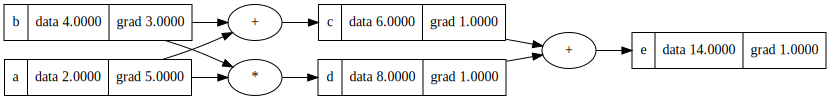

In [77]:
draw_dot(e)

In [11]:
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

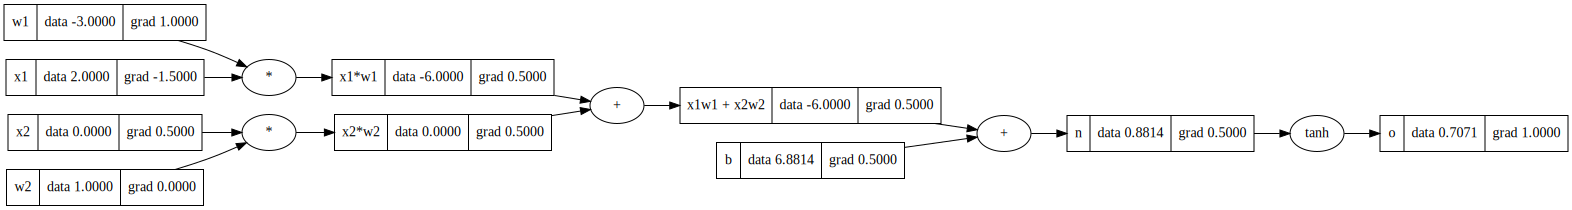

In [12]:
draw_dot(o)

In [13]:
# https://en.wikipedia.org/wiki/Hyperbolic_functions
# input x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1 + x2w2'
n = x1w1x2w2 + b; n.label = 'n'
#----------
# o = n.tanh(); o.label = 'o'
e = (2*n).exp()
o = (e - 1) / (e + 1)
#----------
o.backward()

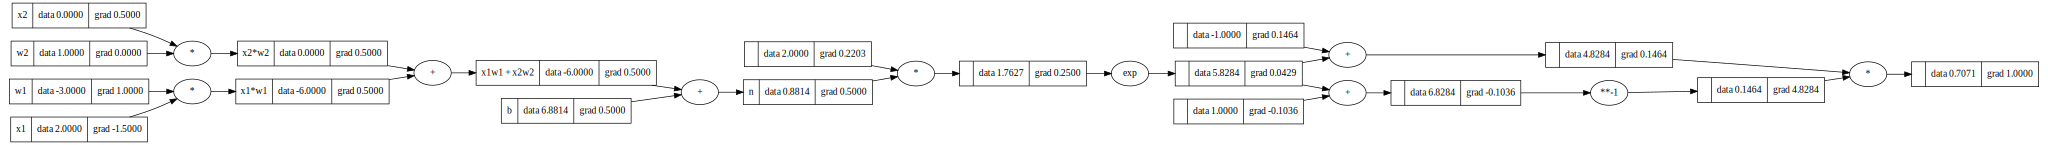

In [14]:
draw_dot(o)

In [15]:
import torch

In [16]:
x1 = torch.Tensor([2.0]).double()             ;x1.requires_grad = True
x2 = torch.Tensor([0.0]).double()             ;x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double()            ;w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()             ;w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ;b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(f'o.data.item() = {o.data.item()}')
o.backward()

print('--------')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

o.data.item() = 0.7071066904050358
--------
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


In [17]:
import random

class Neuron:
    
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1,1))

    def __call__(self, x):
        # w * x + b
        # print(list(zip(self.w, x)), self.b)
        act = sum((wi*xi for wi,xi in zip(self.w, x)), self.b) 
        out = act.tanh()
        return out

    def parameters(self):


        # print(f'w: {self.w}, b: {[self.b]}')

        
        return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
        self.neurons = [Neuron(nin) for _ in range(nout)]

    def __call__(self, x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs

    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        # params = []
        # for neuron in self.neurons:
        #     ps = neuron.parameters()
        #     params.extend(ps)
        # return params


class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x        

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]
        params = []
        # for layer in self.layers:
        #     ps = layer.parameters()
        #     params.extend(ps)
        # return params

In [18]:
x = [2.0, 3.0, -1.0]
n = MLP(3, [4, 4, 1])
n(x)

Value(data = 0.6048015585459858)

In [19]:
print(f'len(n.parameters()): {len(n.parameters())}')
n.parameters()

len(n.parameters()): 41


[Value(data = 0.5496873844802168),
 Value(data = -0.2399855244751743),
 Value(data = 0.910310548428104),
 Value(data = 0.2555220339908375),
 Value(data = -0.09070678029860768),
 Value(data = -0.33991684988873483),
 Value(data = -0.04537975898347346),
 Value(data = 0.6673212664639347),
 Value(data = 0.5576154014004218),
 Value(data = 0.6055655401254394),
 Value(data = 0.44821672252924527),
 Value(data = -0.9048843640945314),
 Value(data = 0.6586041471130213),
 Value(data = -0.16845767740898476),
 Value(data = -0.6965536346723842),
 Value(data = 0.6088801309684264),
 Value(data = 0.8567028035894699),
 Value(data = 0.1851938182447741),
 Value(data = 0.37210467633807265),
 Value(data = -0.25286757208780597),
 Value(data = 0.8964890644104513),
 Value(data = -0.5534185432915921),
 Value(data = 0.9182255345126449),
 Value(data = 0.31026948503588425),
 Value(data = 0.9596073399732041),
 Value(data = 0.791278434694062),
 Value(data = 0.3728364094573122),
 Value(data = -0.8644331750526901),
 Val

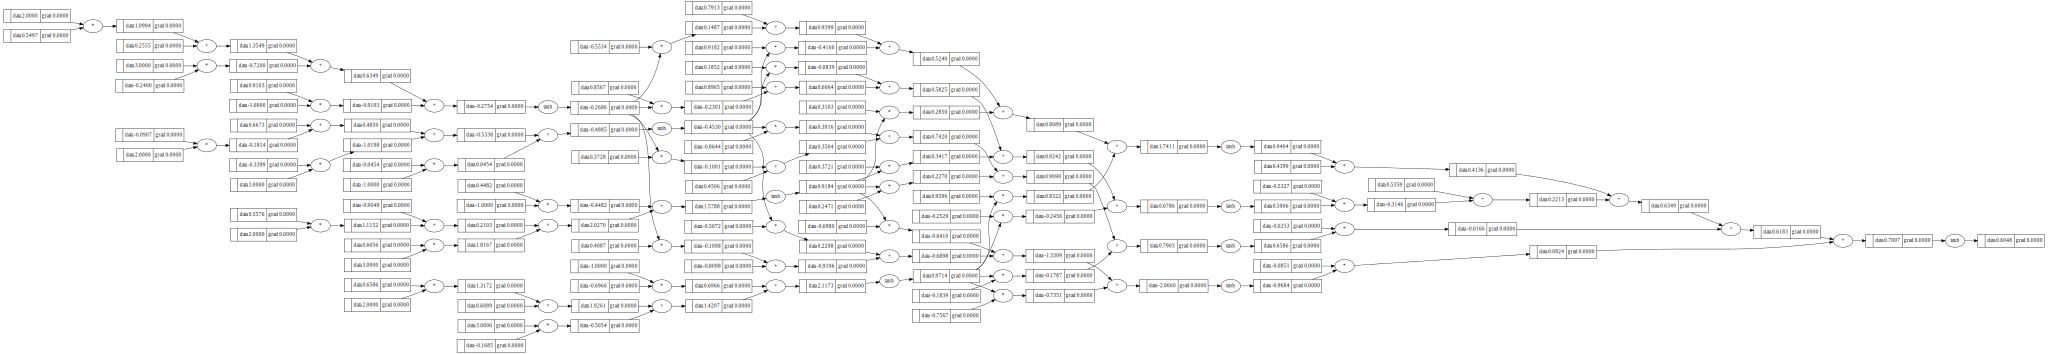

In [20]:
draw_dot(n(x))

In [21]:
# initialize neutral net, 3 inputs, 4 neurons, 4 neurons, 1 output, with random weights and bias
n = MLP(3, [4, 4, 1])

In [22]:
# inputs
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0]    
]
  
# desired targets
ys = [1.0, -1.0, -1.0, 1.0]  

In [23]:
learning_rate = 0.05

for k in range(20):
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))  # low loss is better, perfect is loss = 0

  # backward pass
  for p in n.parameters():
    p.grad = 0.0  # zero the gradient 
  loss.backward()

  # update weights and bias
  for p in n.parameters():
      p.data += -learning_rate * p.grad

  # print(f'x: {x}')
  print(f'ypred: {ypred}')
  print(f'step: {k}, loss: {loss.data}')   
  print('-------')  

ypred: [Value(data = -0.9900819512650837), Value(data = 0.7384109962547425), Value(data = -0.9907059842635058), Value(data = -0.9548556691460772)]
step: 0, loss: 10.804046030571516
-------
ypred: [Value(data = -0.9852771176364689), Value(data = 0.48394932674563507), Value(data = -0.9874507800705022), Value(data = -0.9323313523914502)]
step: 1, loss: 9.877492776515599
-------
ypred: [Value(data = -0.9760770388013834), Value(data = -0.003463738710511781), Value(data = -0.9825089832911942), Value(data = -0.8933505158116607)]
step: 2, loss: 8.483047094732665
-------
ypred: [Value(data = -0.9565344548622646), Value(data = -0.3564082265800596), Value(data = -0.9762714090510143), Value(data = -0.8151651425357193)]
step: 3, loss: 7.537624984582146
-------
ypred: [Value(data = -0.8473084821398559), Value(data = -0.44287699786836615), Value(data = -0.9653826179865515), Value(data = -0.5810139270632554)]
step: 4, loss: 6.223738068395464
-------
ypred: [Value(data = 0.36219921277882844), Value(dat

In [24]:
n.parameters()

[Value(data = 1.2705978136376515),
 Value(data = -0.5727251865454274),
 Value(data = -0.5764174257196172),
 Value(data = -0.251546107318761),
 Value(data = -0.9795310650071767),
 Value(data = 0.3298081470385644),
 Value(data = 0.38398282124917005),
 Value(data = 0.09450249574754473),
 Value(data = -0.35852480755664284),
 Value(data = 0.7437424218502328),
 Value(data = -0.8497687357743294),
 Value(data = -0.5797174660185903),
 Value(data = -0.6264607521857651),
 Value(data = 0.47833637584447075),
 Value(data = 0.15018021079894434),
 Value(data = 0.6673694967782874),
 Value(data = 0.9724753350079075),
 Value(data = -0.47510168292733895),
 Value(data = 0.21141868778546932),
 Value(data = -0.8869985979637249),
 Value(data = 0.7162672395750391),
 Value(data = -0.32327919055963267),
 Value(data = -0.20764510596803842),
 Value(data = 0.7168704791411948),
 Value(data = -0.5890607685917726),
 Value(data = 0.6916748168795647),
 Value(data = 0.5274769041072673),
 Value(data = -0.5389246811957111)

In [25]:
print(f'n.layers[0].neurons[0].w[0].data = {n.layers[0].neurons[0].w[0].data}')
print(f'n.layers[0].neurons[0].w[0].grad = {n.layers[0].neurons[0].w[0].grad}')

n.layers[0].neurons[0].w[0].data = 1.2705978136376515
n.layers[0].neurons[0].w[0].grad = -0.012840799872579418


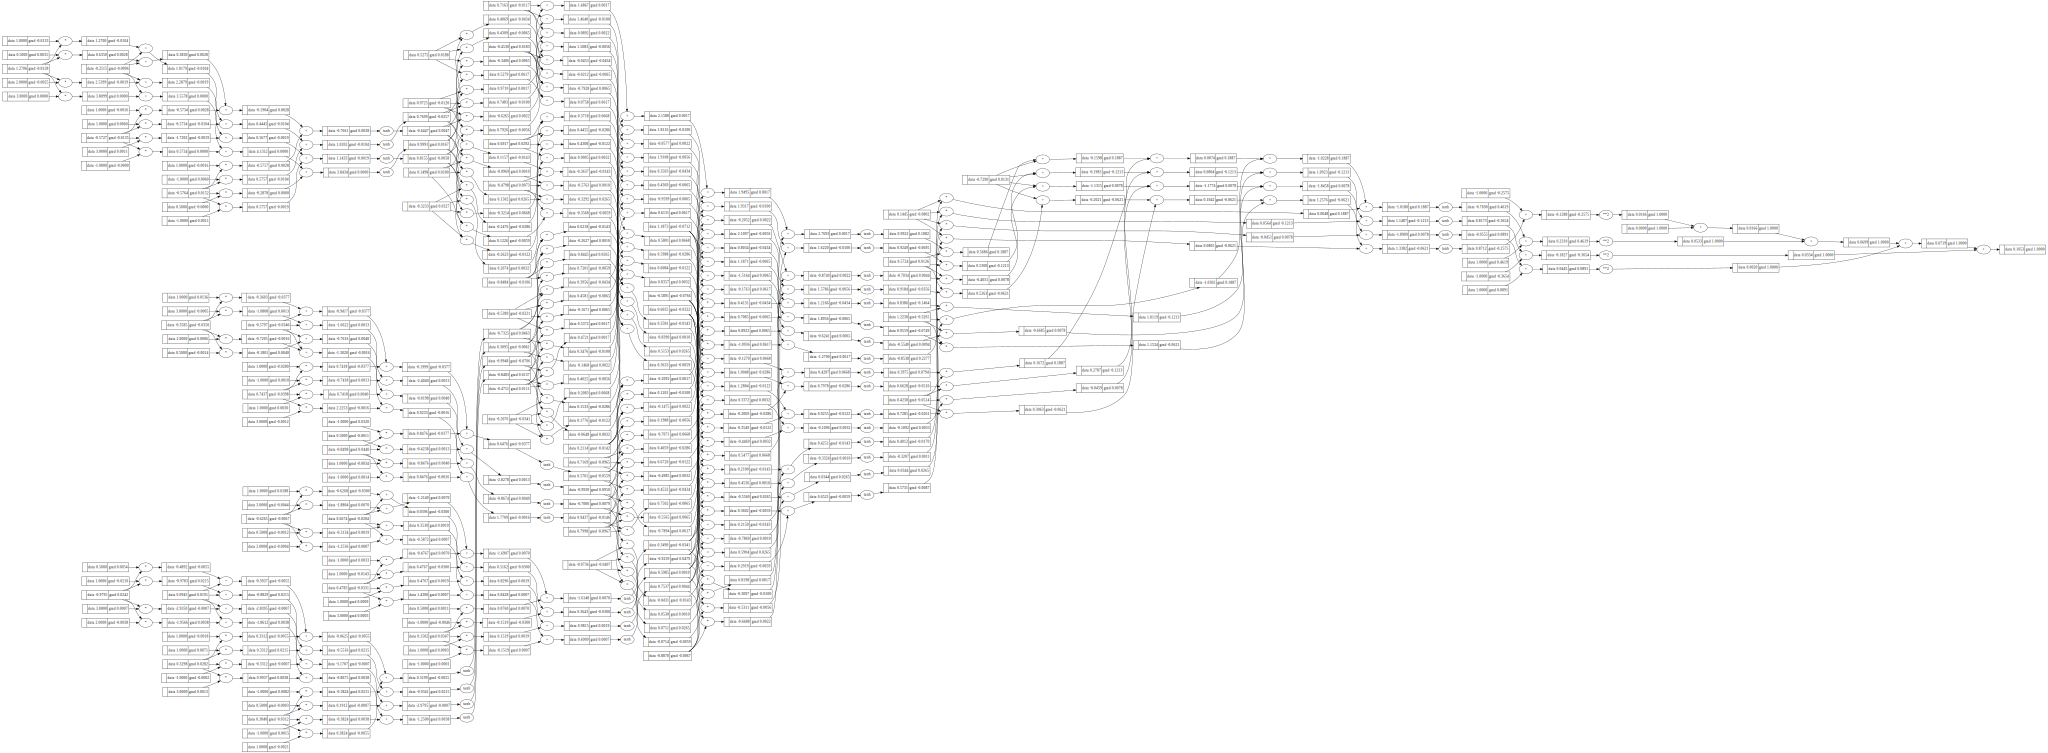

In [26]:
draw_dot(loss)

In [27]:
def lol():  # calculate gradients

  h = .0001

  a = Value(2, label='a')
  b = Value(-3, label='b')
  c = Value(10, label='c')
  e = a*b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L1 = L.data

  # add h to variables to get gradient
  a = Value(2, label='a')
  # a.data += h  # dL/da
  b = Value(-3, label='b')
  b.data += h  # dL/db
  c = Value(10, label='c')
  # c.data += h  # dL/dc
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  # d.data += h  # dL/dd
  f = Value(-2, label='f')
  L = d * f; L.label='L'
  L2 = L.data

  print(f'(L2 -L1)/h = {(L2 -L1)/h}')

lol()
        

(L2 -L1)/h = -4.000000000008441


<function matplotlib.pyplot.grid(visible=None, which='major', axis='both', **kwargs)>

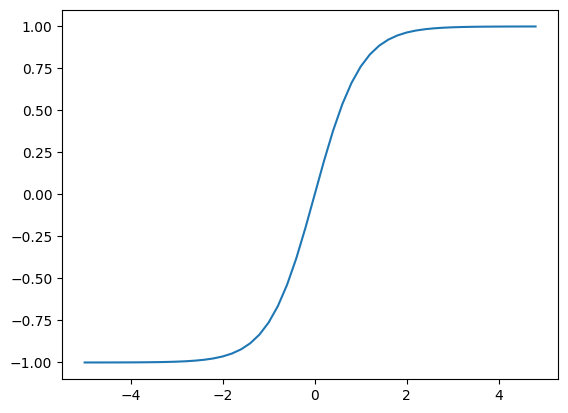

In [28]:
_num = np.arange(-5, 5, 0.2)
plt.plot(_num, np.tanh(_num))
plt.grid